In [1]:
import learn2learn as l2l
import torch
import MamlTools as mt
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [3]:
from learn2learn.data.transforms import (NWays,
                                         KShots,
                                         LoadData,
                                         RemapLabels,
                                         ConsecutiveLabels)

In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    
    def forward(self, x):
        return x.view(x.size(0), -1)
    
def load_maml_conv(**kwargs):
    x_dim = kwargs['x_dim']
    hid_dim = kwargs['hid_dim']
    z_dim = kwargs['z_dim']
    
    def conv_block(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )

    encoder = nn.Sequential(
    conv_block(x_dim, hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, z_dim),
    Flatten()
    )
    
    return encoder

In [6]:
test_files_path = "../ESC-10 Metadata/ESC10TestData.npy"
train_files_path = "../ESC-10 Metadata/ESC10TrainData.npy"
test_labels_path = "../ESC-10 Metadata/ESC10TestLabel.npy"
train_labels_path = "../ESC-10 Metadata/ESC10TrainLabel.npy"
database_path = "../ESC-10 Metadata/ESC10.hdf5"

In [7]:
total_sounds, total_labels = mt.get_dataset(test_files_path, train_files_path, test_labels_path, train_labels_path)

In [8]:
# class labels
label_list = ["baby cry", "chainsaw", "clock tick", "dogbark", "fire cracking", "helicopter", "sneezing", "rain", "rooster", "sea waves"]

In [9]:
# getting random train, test, validation classes from the whole meta dataset in 8:1:1 ratio
classes = torch.randperm(10)
train_classes, val_classes, test_classes = classes[:6], classes[6:8], classes[8:]
print(train_classes, val_classes, test_classes)

tensor([1, 3, 5, 0, 4, 7]) tensor([8, 2]) tensor([6, 9])


In [10]:
train_set = mt.ImageDataset(total_sounds, total_labels, database_path, train_classes, transform = None)
val_set = mt.ImageDataset(total_sounds, total_labels, database_path, val_classes, transform = None)
test_set = mt.ImageDataset(total_sounds, total_labels, database_path, test_classes, transform = None)

In [11]:
train_sounds, train_labels = train_set.get_labels_n_sounds()
val_sounds, val_labels = val_set.get_labels_n_sounds()
test_sounds, test_labels = test_set.get_labels_n_sounds()

In [12]:
n_way = 4
k_shot = 5

In [13]:
train_batches = mt.BatchSampler(n_way, k_shot, train_sounds, train_labels, include_query = True, shuffle = True)
val_batches = mt.BatchSampler(1, 3, val_sounds, val_labels, include_query = True, shuffle = True)
test_batches = mt.BatchSampler(4, 3, test_sounds, test_labels, include_query = True, shuffle = True)

In [14]:
model = load_maml_conv(x_dim = 1, hid_dim = 64, z_dim = 64)

In [15]:
dat = mt.ImageDataset(total_sounds, total_labels, database_path, train_labels, transform = None)
dataset = l2l.data.MetaDataset(dat)
transforms = [
    l2l.data.transforms.NWays(dataset, n=4),
    l2l.data.transforms.KShots(dataset, k=6),
    l2l.data.transforms.LoadData(dataset),
]

In [16]:
tasksets = l2l.data.TaskDataset(dataset, transforms, num_tasks=2000)

In [17]:
maml = l2l.algorithms.MAML(model, lr = 0.001, first_order = True)

In [18]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)
loss = nn.CrossEntropyLoss(reduction='mean')

In [19]:
def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)

In [20]:
def fast_adapt(batch, learner, loss, adaptation_steps, shots, ways, device):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)

    # Separate data into adaptation/evalutation sets
    adaptation_indices = np.zeros(data.size(0), dtype=bool)
    adaptation_indices[np.arange(shots*ways) * 2] = True
    evaluation_indices = torch.from_numpy(~adaptation_indices)
    adaptation_indices = torch.from_numpy(adaptation_indices)
    adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
    evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

    # Adapt the model
    for step in range(adaptation_steps):
        adaptation_error = loss(learner(adaptation_data), adaptation_labels)
        learner.adapt(adaptation_error)

    # Evaluate the adapted model
    predictions = learner(evaluation_data)
    evaluation_error = loss(predictions, evaluation_labels)
    evaluation_accuracy = accuracy(predictions, evaluation_labels)
    return evaluation_error, evaluation_accuracy

In [21]:
# training
num_iterations = 100
ways=4
shots=3
meta_lr=0.003
fast_lr=0.5
meta_batch_size=32
adaptation_steps=1
num_iterations=100
cuda=True
seed=42

In [ ]:
# training
num_iterations = 100
ways=4
shots=3
meta_lr=0.003
fast_lr=0.5
meta_batch_size=32
adaptation_steps=1
num_iterations=100
cuda=True
seed=42

maml.to(device)

for iteration in range(num_iterations):
    optimizer.zero_grad()

    meta_train_error = 0.0
    meta_train_accuracy = 0.0
    meta_valid_error = 0.0
    meta_valid_accuracy = 0.0

    for task in range(32):
        learner = maml.clone()
        batch = tasksets.sample()
        
        evaluation_error, evaluation_accuracy = fast_adapt(batch,
                                                           learner,
                                                           loss,
                                                           adaptation_steps,
                                                           shots,
                                                           ways,
                                                           device)
        
        evaluation_error.backward()
        meta_train_error += evaluation_error.item()
        meta_train_accuracy += evaluation_accuracy.item()
        
        learner = maml.clone()
        batch = tasksets.sample()
        
        evaluation_error, evaluation_accuracy = fast_adapt(batch,
                                                               learner,
                                                               loss,
                                                               adaptation_steps,
                                                               shots,
                                                               ways,
                                                               device)
        meta_valid_error += evaluation_error.item()
        meta_valid_accuracy += evaluation_accuracy.item()
    
    torch.save(learner.state_dict(), "maml_model_parameters.ckpt")
    
    print('\n')
    print('Iteration', iteration)
    print('Meta Train Error', meta_train_error / meta_batch_size)
    print('Meta Train Accuracy', (meta_train_accuracy / meta_batch_size) * 100, "%")
    print('Meta Valid Error', meta_valid_error / meta_batch_size)
    print('Meta Valid Accuracy', (meta_valid_accuracy / meta_batch_size) * 100, "%")

    # Average the accumulated gradients and optimize
    for p in maml.parameters():
        p.grad.data.mul_(1.0 / meta_batch_size)
    optimizer.step()

In [22]:
shot_vals = []

In [23]:
accs = []

In [26]:
ways = 3

maml.to(device)
meta_batch_size = 64

for shots in [2, 4, 6, 8]:
    dat = mt.ImageDataset(total_sounds, total_labels, database_path, train_labels, transform = None)
    dataset = l2l.data.MetaDataset(dat)
    transforms = [
        l2l.data.transforms.NWays(dataset, n = 4),
        l2l.data.transforms.KShots(dataset, k = shots * 2),
        l2l.data.transforms.LoadData(dataset),
    ]
    tasksets = l2l.data.TaskDataset(dataset, transforms, num_tasks=2000)

    meta_test_error = 0.0
    meta_test_accuracy = 0.0
    
    for task in range(meta_batch_size):
        # Compute meta-testing loss
        learner = maml.clone()
        learner.load_state_dict(torch.load("maml_model_parameters.ckpt"))
        learner.eval()
        batch = tasksets.sample()
        evaluation_error, evaluation_accuracy = fast_adapt(batch,
                                                            learner,
                                                            loss,
                                                            adaptation_steps,
                                                            shots,
                                                            ways,
                                                            device)
        meta_test_error += evaluation_error.item()
        meta_test_accuracy += evaluation_accuracy.item()
        
    print("For {} shots:".format(shots))
    print('Meta Test Error', meta_test_error / meta_batch_size)
    print('Meta Test Accuracy', (meta_test_accuracy / meta_batch_size) * 100, "%")
    accs.append((meta_test_accuracy / meta_batch_size) * 100)
    shot_vals.append(shots)

For 2 shots:
Meta Test Error 1.8734911817591637
Meta Test Accuracy 61.7187509778887 %
For 4 shots:
Meta Test Error 1.59246124594938
Meta Test Accuracy 67.5000011920929 %
For 6 shots:
Meta Test Error 1.6321208043955266
Meta Test Accuracy 65.88542107492685 %
For 8 shots:
Meta Test Error 1.7831605144310743
Meta Test Accuracy 62.61718855239451 %


In [33]:
print(accs)
print(shot_vals)

[63.28125102445483, 66.09375120606273, 66.56250422820449, 65.15625105239451]
[2.0, 4.0, 6.0, 8.0]


In [34]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [36]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticksplt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)     

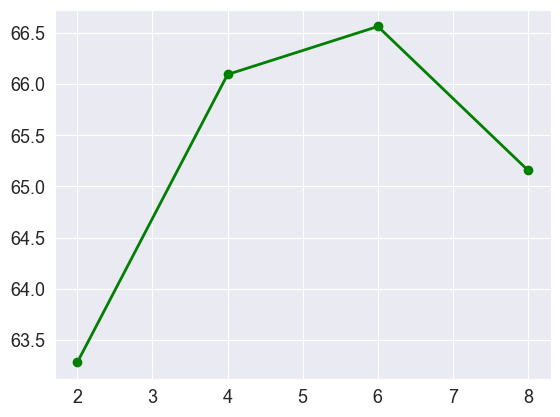

In [40]:
plt.plot(shot_vals, accs, "go", linewidth = 2, linestyle = "-")